In [1]:
# https://www.tensorflow.org/tutorials/text/image_captioning
# https://www.kaggle.com/code/dschettler8845/bms-image-captioning-w-attention-train
# https://github.com/tensorflow/models/tree/master/research/attention_ocr
# https://github.com/vuducnghia/attention-ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'ImageCaptioning'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=6).remove_rare_chars(2)
print(dataset)

Number of images found: 4069
Number of labels found: 4069
Number of unique characters: 2033
Characters present: {'浪': 308, '㐌': 304, '\U000f070b': 236, '朱': 234, '𠊛': 232, '\U000f047c': 215, '尼': 215, '娘': 206, '𢚸': 202, '固': 201, '吏': 201, '𦋦': 191, '拱': 180, '之': 163, '埃': 159, '群': 153, '𠳒': 150, '情': 147, '芇': 147, '買': 147, '別': 134, '欺': 125, '麻': 125, '𠓨': 124, '𠬠': 124, '仙': 120, '𡗶': 116, '爫': 116, '𧗱': 114, '花': 106, '𦖑': 105, '浽': 104, '𠄩': 102, '呐': 102, '命': 102, '渚': 101, '塘': 99, '饒': 98, '𠫾': 97, '些': 97, '渃': 97, '如': 96, '時': 95, '強': 94, '分': 93, '低': 92, '𡢐': 91, '傷': 91, '払': 91, '牢': 88, '𫽄': 85, '仍': 83, '咍': 82, '冲': 81, '昆': 81, '鐄': 81, '於': 80, '身': 79, '庒': 79, '生': 77, '𧡊': 77, '月': 76, '𢬣': 75, '𣈜': 75, '沛': 74, '調': 74, '茹': 74, '﨤': 72, '皮': 72, '油': 71, '\U000f061a': 71, '細': 71, '催': 70, '公': 70, '典': 70, '緣': 69, '畧': 68, '戈': 68, '碎': 67, '排': 67, '爲': 66, '𠁀': 64, '娥': 64, '\U000f02c7': 62, '包': 61, '共': 61, '貝': 59, '𢧚': 58, '㗂': 57, '恩': 57, '賒': 

## Data constants and input pipeline

In [5]:
HEIGHT = 148
WIDTH = 32
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
MAX_LENGTH = data_handler.max_length
PADDING_TOKEN = data_handler.padding_token
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 16

## Visualize the data

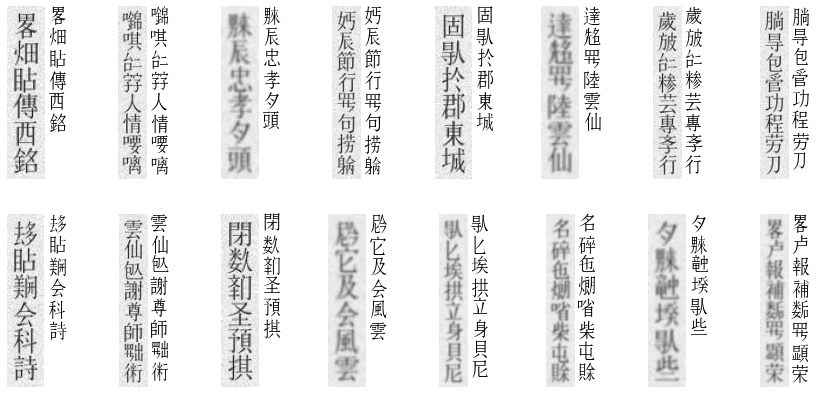

In [8]:
from visualizer import visualize_images_labels
img_paths, labels = dataset.img_paths, dataset.labels 
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

# Define model components

In [9]:
from tensorflow.keras.layers import (
    Input, Embedding, Dropout, Dense, GRU, 
    Concatenate, GlobalAveragePooling1D, 
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_rnn
EMBEDDING_DIM = 512
UNITS = 1024

In [10]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

## The encoder

In [11]:
def CNN_Encoder(imagenet_model=None, imagenet_output_layer=None, name='CNN_encoder'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        features = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        features = custom_cnn(conv_blocks_config, image_input)

    # Adding pixel coordinates to image features
    batch_size, h, w, _ = tf.shape(features)
    x, y = tf.meshgrid(tf.range(w), tf.range(h))
    w_loc = tf.one_hot(x, depth=w)
    h_loc = tf.one_hot(y, depth=h)
    loc = tf.concat([h_loc, w_loc], axis=2)
    loc = tf.tile(tf.expand_dims(loc, 0), multiples=[batch_size, 1, 1, 1])
    
    # (batch_size, height, width, num_features + coord)
    features = tf.concat([features, loc], axis=3) 
    features = reshape_for_rnn(features, dim_to_keep=1)
    return tf.keras.Model(inputs=image_input, outputs=features, name=name)

## The attention head

In [12]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, name='BahdanauAttention', **kwargs):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 17, encoder_channels)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 17, units)
        attention_hidden_layer = self.W1(features) + self.W2(hidden_with_time_axis)
        attention_hidden_layer = tf.nn.tanh(attention_hidden_layer)

        # score shape == (batch_size, 17, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 17, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, encoder_channels)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## The decoder

In [13]:
def RNN_Decoder(enc_output_shape, vocab_size, name='RNN_Decoder'):
    token_input = Input(shape=(1,), name='new_token')
    features_input = Input(shape=enc_output_shape, name='encoder_output')
    pre_hidden_input = Input(shape=(UNITS,), name='previous_state')
    
    # Defining attention as a separate model
    attention = BahdanauAttention(UNITS)
    context_vector, attention_weights = attention(features_input, pre_hidden_input)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = Concatenate(axis=-1, name='context_and_embedding')([
        tf.expand_dims(context_vector, 1), 
        Embedding(vocab_size, EMBEDDING_DIM)(token_input)
    ])
    
    # Passing the concatenated vector to the GRU
    rnn_output, state = GRU(
        units = UNITS, 
        return_state = True, 
        return_sequences = True, 
    )(x, initial_state=pre_hidden_input)

    x = Dropout(0.4)(rnn_output)
    x = Dense(UNITS, name='dense')(x)
    x = GlobalAveragePooling1D(name='average_pool')(x)
    y_pred = Dense(vocab_size, name='prediction')(x)

    return tf.keras.Model(
        inputs = [token_input, features_input, pre_hidden_input], 
        outputs = [y_pred, state, attention_weights],
        name = name
    )

# Customize `Model.fit `

In [14]:
class AttentionCRNN(tf.keras.Model):
    def __init__(self, encoder, decoder, name='AttentionCRNN'):
        super(AttentionCRNN, self).__init__(name=name)
        self.encoder = encoder
        self.decoder = decoder
    
    def get_config(self):
        return {
            'encoder': CNN_Encoder(imagenet_model, imagenet_output_layer), 
            'decoder': RNN_Decoder(self.encoder.output_shape[1:], VOCAB_SIZE)
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Custom training loop

In [15]:
@tf.function
def _compute_loss(self, batch):
    dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1) 
    hidden = tf.zeros((BATCH_SIZE, UNITS), tf.float32)

    batch_images, batch_tokens = batch
    features = self.encoder(batch_images)
    loss = tf.constant(0.0)

    for i in range(1, MAX_LENGTH):
        # Passing the features through the decoder
        preds, hidden, _ = self.decoder([dec_input, features, hidden])
        loss += self.loss(batch_tokens[:, i], preds) 
        
        # Use teacher forcing
        dec_input = tf.expand_dims(batch_tokens[:, i], 1) 
    
    # Update metrics
    predictions = self.predict(batch_images) 
    self.compiled_metrics.update_state(batch_tokens, predictions)
    
    display_result = {'loss': loss / MAX_LENGTH}
    display_result.update({m.name: m.result() for m in self.metrics})
    return loss, display_result

In [16]:
@tf.function
def train_step(self, batch):
    with tf.GradientTape() as tape:
        loss, display_result = self._compute_loss(batch)

    # Apply an optimization step
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    return display_result

@tf.function
def test_step(self, batch):
    _, display_result = self._compute_loss(batch)
    return display_result

## Custom prediction

In [17]:
@tf.function
def predict(self, batch_images, return_attention=False):
    batch_size = batch_images.shape[0]
    new_tokens = tf.fill([batch_size, 1], START_TOKEN)
    result_tokens, attentions = [new_tokens], []

    hidden = tf.zeros((batch_size, UNITS), tf.float32)
    features = self.encoder(batch_images)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(1, MAX_LENGTH):
        last_tokens = new_tokens
        preds, hidden, attention_weights = self.decoder([last_tokens, features, hidden])
        new_tokens = tf.expand_dims(tf.argmax(preds, axis=-1), 1) 

        # If a sequence produces an `END_TOKEN`, set it `done` after that
        done = done | (last_tokens == END_TOKEN)

        # Once a sequence is done it only produces PADDING_TOKEN
        new_tokens = tf.where(done, PADDING_TOKEN, new_tokens)
        result_tokens.append(new_tokens)

        attentions.append(attention_weights)
        if tf.executing_eagerly() and tf.reduce_all(done): break

    result_tokens = tf.concat(result_tokens, axis=-1)
    if return_attention: return result_tokens, tf.concat(attentions, axis=-1)
    return result_tokens

## Summary

In [18]:
AttentionCRNN._compute_loss = _compute_loss
AttentionCRNN.train_step = train_step
AttentionCRNN.test_step = test_step
AttentionCRNN.predict = predict

In [19]:
encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
decoder = RNN_Decoder(encoder.output_shape[1:], VOCAB_SIZE)
model = AttentionCRNN(encoder, decoder)

In [20]:
encoder.summary(line_length=120)
print()
decoder.summary(line_length=125)

Model: "CNN_encoder"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, 148, 32, 1)]       0             []                                      
                                                                                                                        
 block1_conv1 (Conv2D)                 (None, 148, 32, 64)        640           ['image[0][0]']                         
                                                                                                                        
 block1_bn1 (BatchNormalization)       (None, 148, 32, 64)        256           ['block1_conv1[0][0]']                  
                                                                                                                        
 block1_act

                                        (17, 1)]                                 'tf.range_1[0][0]']                    
                                                                                                                        
 tf.one_hot_1 (TFOpLambda)             (17, 1, 17)                0             ['tf.meshgrid[0][1]',                   
                                                                                 'tf.__operators__.getitem_1[0][0]']    
                                                                                                                        
 tf.one_hot (TFOpLambda)               (17, 1, 1)                 0             ['tf.meshgrid[0][0]',                   
                                                                                 'tf.__operators__.getitem_2[0][0]']    
                                                                                                                        
 tf.concat (TFOpLambda)         

# Training

In [21]:
from tensorflow.keras.optimizers import Adam
from kfold import kfold_decorator
from metrics import MeanEditDistance
from losses import MaskedLoss

In [22]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from callbacks import EarlyStoppingWithStuck
LEARNING_RATE = 2e-4
EPOCHS = 100

## Callbacks

In [23]:
stuck_str = 'epoch > 15 and val_loss > 4'
early_stopping_callback = EarlyStoppingWithStuck(patience=5, stuck_str=stuck_str)

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 3, # Reduce if no improvement after 3 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [24]:
@kfold_decorator(n_splits=10, random_state=2022, is_subclassed_model=True)
def train(model, img_paths, labels, train_idxs=None, valid_idxs=None):
    train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE, True)
    valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE, True)
    
    model.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE), 
        loss = MaskedLoss(PADDING_TOKEN), 
        metrics = [MeanEditDistance(PADDING_TOKEN)]
    )
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
            early_stopping_callback,
            reduce_lr_callback, 
#             schedule_lr_callback, 
        ],
        verbose = 1
    ).history
    return valid_tf_dataset, early_stopping_callback.best_epoch, history, model

In [25]:
%%time
valid_datasets, best_epochs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
228/228 [==============================] - 25s 61ms/step - loss: 5.4166 - edist: 8.0692 - val_loss: 5.0122 - val_edist: 7.8528 - lr: 2.0000e-04
Epoch 2/100
228/228 [==============================] - 11s 50ms/step - loss: 5.0526 - edist: 7.3132 - val_loss: 4.8168 - val_edist: 7.1118 - lr: 2.0000e-04
Epoch 3/100
228/228 [==============================] - 12s 51ms/step - loss: 4.8391 - edist: 7.4181 - val_loss: 4.6961 - val_edist: 7.4685 - lr: 2.0000e-04
Epoch 4/100
228/228 [==============================] - 12s 51ms/step - loss: 4.6269 - edist: 7.1402 - val_loss: 4.6344 - val_edist: 6.8854 - lr: 2.0000e-04
Epoch 5/100
228/228 [==============================] - 12s 51ms/step - loss: 4.4510 - edist: 6.9942 - val_loss: 4.6353 - val_edist: 7.0936 - lr: 2.0000e-04
Epoch 6/100
228/228 [==============================] - 12s 51ms/step - loss: 4.2712 - edist: 6.8289 - val_loss: 4.7386 - val_edist: 6.8430 - lr: 2.0000e-04
Epoch 7/100
228/2

Epoch 51/100
228/228 [==============================] - 12s 52ms/step - loss: 1.7530e-04 - edist: 0.0000e+00 - val_loss: 0.5189 - val_edist: 1.0002 - lr: 1.0000e-04
Epoch 52/100
228/228 [==============================] - 12s 52ms/step - loss: 1.5703e-04 - edist: 0.0000e+00 - val_loss: 0.5164 - val_edist: 1.0000 - lr: 1.0000e-04
Epoch 53/100
228/228 [==============================] - 12s 52ms/step - loss: 1.4057e-04 - edist: 0.0000e+00 - val_loss: 0.5141 - val_edist: 1.0000 - lr: 1.0000e-04
Epoch 54/100
228/228 [==============================] - 12s 52ms/step - loss: 1.2574e-04 - edist: 0.0000e+00 - val_loss: 0.5123 - val_edist: 0.9684 - lr: 1.0000e-04
Epoch 55/100
228/228 [==============================] - 12s 52ms/step - loss: 1.1237e-04 - edist: 0.0000e+00 - val_loss: 0.5107 - val_edist: 0.9683 - lr: 1.0000e-04
Epoch 56/100
228/228 [==============================] - 12s 52ms/step - loss: 1.0036e-04 - edist: 0.0000e+00 - val_loss: 0.5097 - val_edist: 0.9653 - lr: 1.0000e-04
Epoch 57/1

============== Fold 02 training ==============
Epoch 1/100
228/228 [==============================] - 23s 63ms/step - loss: 5.4144 - edist: 8.0347 - val_loss: 5.0268 - val_edist: 7.9761 - lr: 2.0000e-04
Epoch 2/100
228/228 [==============================] - 12s 52ms/step - loss: 5.0786 - edist: 7.6094 - val_loss: 4.9448 - val_edist: 7.8329 - lr: 2.0000e-04
Epoch 3/100
228/228 [==============================] - 12s 53ms/step - loss: 4.9257 - edist: 7.0959 - val_loss: 4.8129 - val_edist: 7.4115 - lr: 2.0000e-04
Epoch 4/100
228/228 [==============================] - 12s 53ms/step - loss: 4.7267 - edist: 7.0013 - val_loss: 4.6827 - val_edist: 7.0289 - lr: 2.0000e-04
Epoch 5/100
228/228 [==============================] - 12s 53ms/step - loss: 4.5372 - edist: 7.1557 - val_loss: 4.6547 - val_edist: 7.1243 - lr: 2.0000e-04
Epoch 6/100
228/228 [==============================] - 12s 53ms/step - loss: 4.3918 - edist: 7.0199 - val_loss: 4.6497 - val_edist: 7.1824 - lr: 2.0000e-04
Epoch 7/100
228/2

Epoch 4/100
228/228 [==============================] - 12s 51ms/step - loss: 4.6144 - edist: 7.1050 - val_loss: 4.8066 - val_edist: 7.2555 - lr: 2.0000e-04
Epoch 5/100
228/228 [==============================] - 12s 51ms/step - loss: 4.4575 - edist: 7.0127 - val_loss: 4.8287 - val_edist: 7.2460 - lr: 2.0000e-04
Epoch 6/100
228/228 [==============================] - 12s 51ms/step - loss: 4.3078 - edist: 6.8657 - val_loss: 4.8764 - val_edist: 6.9952 - lr: 2.0000e-04
Epoch 7/100
227/228 [============================>.] - ETA: 0s - loss: 4.1526 - edist: 6.8229
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
228/228 [==============================] - 12s 51ms/step - loss: 4.1533 - edist: 6.9115 - val_loss: 4.8712 - val_edist: 6.9633 - lr: 2.0000e-04
Epoch 8/100
228/228 [==============================] - 12s 52ms/step - loss: 3.9198 - edist: 6.9941 - val_loss: 4.9602 - val_edist: 6.9422 - lr: 1.0000e-04
Epoch 9/100
228/228 [==============================] - 12s 52m

228/228 [==============================] - 12s 52ms/step - loss: 0.3053 - edist: 0.4079 - val_loss: 1.7146 - val_edist: 2.9782 - lr: 2.0000e-04
Epoch 16/100
228/228 [==============================] - 12s 52ms/step - loss: 0.1723 - edist: 0.3568 - val_loss: 1.4924 - val_edist: 2.7519 - lr: 2.0000e-04
Epoch 17/100
228/228 [==============================] - 12s 52ms/step - loss: 0.1226 - edist: 0.0969 - val_loss: 1.3144 - val_edist: 2.5191 - lr: 2.0000e-04
Epoch 18/100
228/228 [==============================] - 12s 52ms/step - loss: 0.0804 - edist: 0.0493 - val_loss: 1.2573 - val_edist: 2.2853 - lr: 2.0000e-04
Epoch 19/100
228/228 [==============================] - 12s 51ms/step - loss: 0.0589 - edist: 0.0400 - val_loss: 1.3534 - val_edist: 2.3877 - lr: 2.0000e-04
Epoch 20/100
228/228 [==============================] - 12s 52ms/step - loss: 0.0505 - edist: 0.0093 - val_loss: 1.3162 - val_edist: 2.3215 - lr: 2.0000e-04
Epoch 21/100
228/228 [==============================] - ETA: 0s - loss:

## Get the best CRNN model and its results

In [26]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset,
    best_fold_epoch,
    best_history,
    best_model,
    best_fold_idx, 
    best_loss,
) = get_best_fold(valid_datasets, best_epochs, histories, models, verbose=2)

25/25 - 1s - loss: 0.4357 - edist: 0.7321 - 706ms/epoch - 28ms/step
25/25 - 1s - loss: 4.6246 - edist: 7.0936 - 706ms/epoch - 28ms/step
25/25 - 1s - loss: 4.3360 - edist: 6.9093 - 721ms/epoch - 29ms/step
25/25 - 1s - loss: 4.8871 - edist: 7.2520 - 710ms/epoch - 28ms/step
25/25 - 1s - loss: 0.9507 - edist: 1.0754 - 705ms/epoch - 28ms/step
25/25 - 1s - loss: 4.9023 - edist: 6.8022 - 713ms/epoch - 29ms/step
25/25 - 1s - loss: 4.8066 - edist: 7.2555 - 709ms/epoch - 28ms/step
25/25 - 1s - loss: 4.5585 - edist: 7.0165 - 681ms/epoch - 27ms/step
25/25 - 1s - loss: 0.5783 - edist: 1.2390 - 711ms/epoch - 28ms/step
25/25 - 1s - loss: 0.7163 - edist: 1.3030 - 700ms/epoch - 28ms/step


Fold 01 has the best result at epoch 100:
- Loss on validation: 0.43573495745658875
- Mean edit distance: 0.7320601344108582


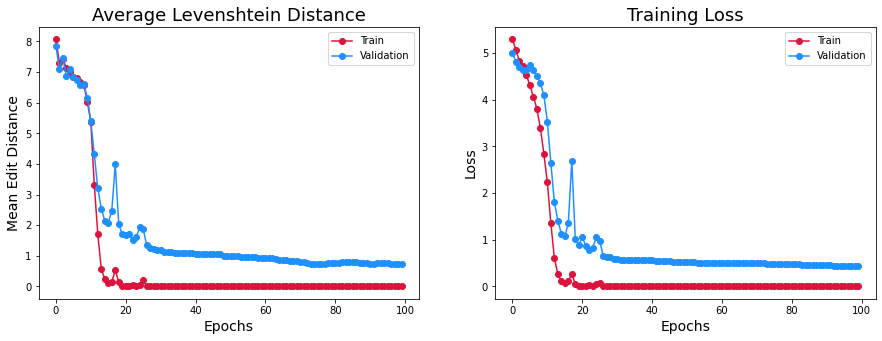

In [27]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_history["val_edist"][best_fold_epoch]}')

plot_training_results(best_history, f'{APPROACH_NAME}.png')
best_model.encoder.save_weights(f'{APPROACH_NAME}_encoder.h5')
best_model.decoder.save_weights(f'{APPROACH_NAME}_decoder.h5')

# Inference

In [28]:
encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
decoder = RNN_Decoder(encoder.output_shape[1:], VOCAB_SIZE)
encoder.load_weights(f'{APPROACH_NAME}_encoder.h5')
decoder.load_weights(f'{APPROACH_NAME}_decoder.h5')

In [29]:
reloaded_model = AttentionCRNN(encoder, decoder)
reloaded_model.compile(
    optimizer = Adam(learning_rate=LEARNING_RATE), 
    loss = MaskedLoss(PADDING_TOKEN), 
    metrics = [MeanEditDistance(PADDING_TOKEN)]
)

## On test dataset

Batch 01:
- True: {1: '𤳆辰忠孝\U000f094e頭', 2: '𣎃㝵包𬋩功程劳刀', 3: '吹柴傷伵㤕車𥪝𢚸', 4: '咍\U000f047c昆唉胡𪟽', 5: '𡢐油鄧𡦂顕荣', 6: '雲仙倍且謝恩', 7: '咍\U000f047c𠬠屡山\U000f025f蹺些', 8: '民𦖑㗂呐請台', 9: '䜹浪固党娄\U000f047c', 10: '碎吀𦋦飭英豪', 11: '民浪屡奴群低', 12: '戈䀡\U000f061a倍踈兮㐌仃', 13: '嗔蹺拱妾𡊰恩朱払', 14: '𧵑尼\U000f047c𧵑沕爲', 15: '本渚別氏固欺覔𢚸', 16: '妾嗔爫𠬠排书謝辞'}
- Pred: {1: '𤳆辰差孝\U000f094e頭', 2: '𣎃㝵包改功程劳刀', 3: '吹柴傷伵㤕車𥪝𢚸', 4: '咍\U000f047c昆唉胡𪟽', 5: '𡢐油鄧𡦂顕荣', 6: '雲仙倍且謝恩', 7: '咍\U000f047c𠬠茦泊\U000f025f蹺些', 8: '民𦖑㗂呐請台', 9: '䜹浪固党雲\U000f047c', 10: '碎吀𦋦飭英豪', 11: '民浪堆奴群低', 12: '戈䀡\U000f061a倍淶身㐌仃', 13: '嗔蹺拱妾畑恩朱払', 14: '𧵑尼\U000f047c𧵑𣳔爲', 15: '本渚別色固欺盃𢚸', 16: '妾嗔爫𠬠排书謝詩'}

Batch 02:
- True: {1: '\U000f0778畨宋玉拱\U000f07f4西詩', 2: '汝句愈出愈奇', 3: '埃咍才𡛔劍夷才𤳆', 4: '𢪀𠇮麻喭朱𠇮', 5: '浽恩渚呂浽情吏芒', 6: '𤾓𠄼朱論𡦂從貝安', 7: '𬌓𢚸娥女爲払麻迎', 8: '哙浪芇𥘷过兒', 9: '𣅶芇吒領役官', 10: '吒願呂特\U000f0482尼辰傕', 11: '䀡𦝄耒吏想情故人', 12: '嘆浪𠦳淡山川', 13: '漢明姓字水支圭茄', 14: '𡦂浪朋友之交', 15: '𨑗棱𧯶易𠬠核', 16: '朱𠫾𠬠妸小童'}
- Pred: {1: '\U000f0778畨宋玉拱紅西詩', 2: '汝句恩㐌慈奇', 3: '埃咍才𡛔制夷才𤳆', 4: '𢪀𠇮麻喭朱𠇮', 5: '浽恩渚呂浽情吏芒', 6: '𤾓𠄼朱論𡦂從貝安', 7: '𬌓𢚸

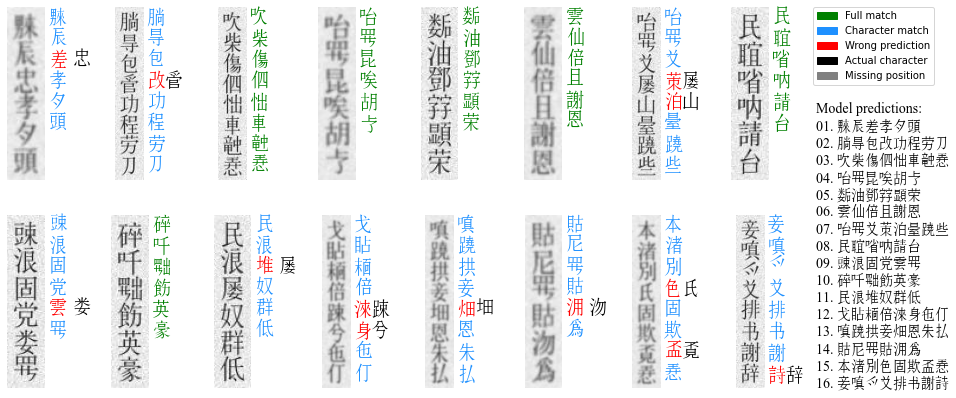

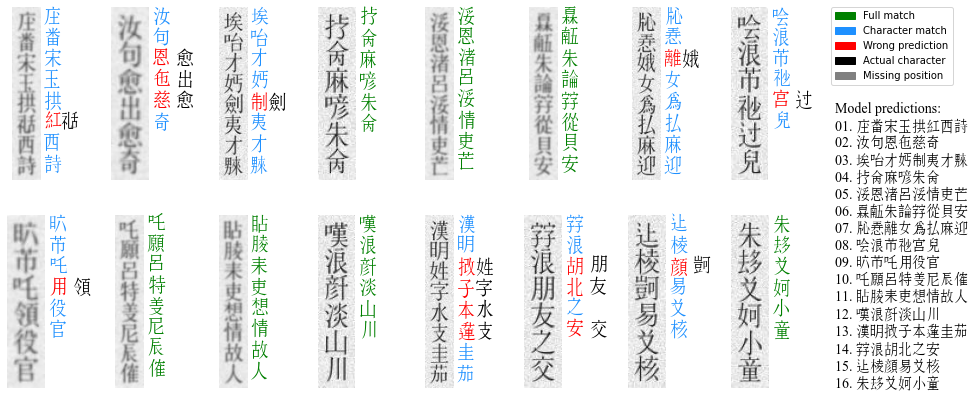

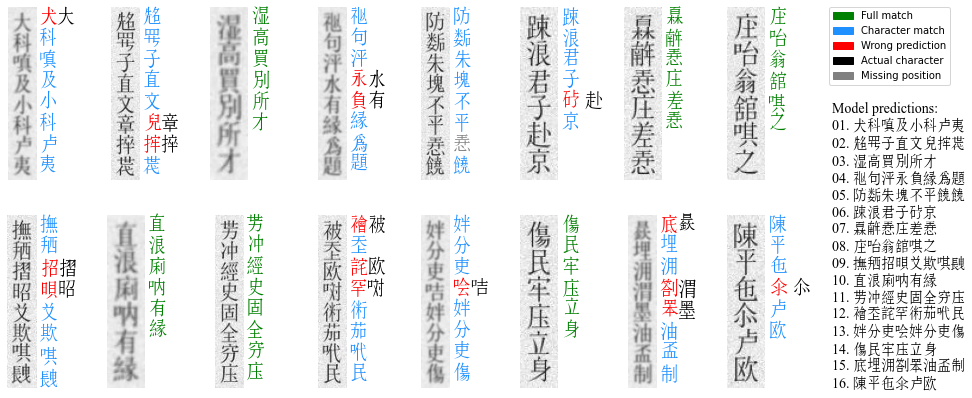

In [30]:
batch_results = []
valid_tf_dataset, valid_idxs = best_valid_dataset
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    pred_tokens, attentions = reloaded_model.predict(batch_images, return_attention=True) 
    
    labels = data_handler.tokens2texts(batch_tokens)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    batch_results.append({'true': labels, 'pred': pred_labels, 'attentions': attentions})

    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [37]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = data_handler.process_image(random_path)
pred_tokens = reloaded_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

Predicted text: 大桃吏記全書


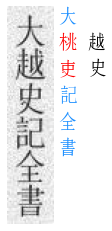

In [51]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))